## [Computational Social Science] Project 5: Natural Language Processing
**Group 3: Jose Aveldanes, Shruti Bathia, and Diana Casanova**

## 1. Introduction
In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()
from sklearn.preprocessing import StandardScaler

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#LDA Topic Modeling
from sklearn.decomposition import LatentDirichletAllocation , NMF

# gensim
import gensim
from gensim import models
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#WordCloud for EDA
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#removing emojis
import re

#import emoji
#import scattertext as st

from sklearn.decomposition import PCA

##machine learning and classification part 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

##helps deal with the Spanish words issue with word corpus method
import nltk

## 2. Data

In [2]:
congress_tweets = pd.read_csv("116th Congressional Tweets and Demographics.csv")
congress_tweets = congress_tweets.dropna(subset = ['text']).reset_index()
numpy.random.seed(44)
congress_tweets = congress_tweets.sample(frac=0.005, random_state=1)
congress_tweets = congress_tweets.reset_index(drop = True)
congress_tweets.head()
# COMPLETE - fill in this line of code with a sufficient number of tweets, depending on your computational resources
# COMPLETE congress_tweets = congress_tweets.sample(...)

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,217331,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. http...,Val Demings,Rep,3-Jan-17,3/12/1957,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447"
1,258764,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,GA,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688"
2,50091,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744"
3,205601,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,FL,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447"
4,85993,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,CA,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958"


## 3. Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [3]:
nlp = en_core_web_sm.load()

In [4]:
def remove_emojis(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F" #emoticons  
        u"\U0001F300-\U0001F5FF" #symbols & pictographs 
        u"\U0001F680-\U0001F6FF" #transport & map symbols
        u"\U0001F1E0-\U0001F1FF" #flags(iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"   
        "]+", 
        flags=re.UNICODE,)
    return emoji_pattern.sub(r"", string)

In [5]:
congress_tweets['text_deEmojify'] = congress_tweets['text'].map(lambda x: remove_emojis(x))

In [6]:
print(congress_tweets.iloc[5]['text_deEmojify']) #checking to see if emojis were removed

RT @Johnson4Dallas This is the most accurate description of the current City of Dallas budget debate (and surrounding noise) that I have read thus far. Kudos to the author for helping to arm the residents of Dallas with actual facts instead of useless political gossip. https://texasscorecard.com/commentary/montoya-citizens-matter-not-city-hall-brawls/


In [7]:
#Removing new line
congress_tweets["text_deEmojify"] = congress_tweets["text_deEmojify"].str.replace('\n','')
#Removing New Line Breaks
congress_tweets["text_deEmojify"] = congress_tweets["text_deEmojify"].str.replace('•','')

In [8]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    nlp.Defaults.stop_words |= {"amp", "RT", "today", "rt", "Today"}
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [9]:
congress_tweets['tokens'] = congress_tweets['text_deEmojify'].map(lambda x: rem_punc_stop(x))
congress_tweets['tokens']

0       [Thank, testifying, Mr, Blake, QT, JRBlake, Re...
1       [My, Twitter, Town, Hall, healthcare, begun, I...
2       [Scipio, Jones, ‘, fight, civil, rights, equal...
3       [There, better, time, ActOnClimate, EarthDay, ...
4       [I, understand, VA, problems, recruiting, qual...
                              ...                        
4729    [If, Senate, action, week, millions, strugglin...
4730    [CA, epicenter, nation, COVID19, pandemic, SoC...
4731    [Competed, Wisconsin, State, Frog, Jump, Champ...
4732    [WYPR881FM, SenatorCardin, joined, MiddayWYPR,...
4733    [SecBernhardt, RepTjCox, This, funny, RepTJCox...
Name: tokens, Length: 4734, dtype: object

In [10]:
#first convert to string from object
congress_tweets['percent_trump_16'] = congress_tweets.trump_2016_state_share.astype(str)
congress_tweets['percent_clinton_16'] = congress_tweets.clinton_2016_state_share.astype(str)
congress_tweets['percent_obama_12'] = congress_tweets.obama_2012_state_share.astype(str)
congress_tweets['percent_romney_12'] = congress_tweets.romney_2012_state_share.astype(str)

In [11]:
##move commas and conver to float
def decommify(s):
    return float("".join([ch for ch in s if ch != ',']))
#Now run through, remove strings and return floats
congress_tweets['percent_trump16'] = congress_tweets['percent_trump_16'].apply(decommify)
congress_tweets['percent_clinton16'] = congress_tweets['percent_clinton_16'].apply(decommify)
congress_tweets['percent_obama12'] = congress_tweets['percent_obama_12'].apply(decommify)
congress_tweets['percent_romney12'] = congress_tweets['percent_romney_12'].apply(decommify)

In [12]:
congress_tweets['sum_2016'] = congress_tweets['percent_trump16'] + congress_tweets['percent_clinton16'] 
congress_tweets['sum_2012'] = congress_tweets['percent_obama12'] + congress_tweets['percent_romney12'] 
congress_tweets['sum_2016']
congress_tweets['sum_2012']

0        8401203.0
1        3852515.0
2        1042153.0
3        8401203.0
4       12694243.0
           ...    
4729     4679825.0
4730    12694243.0
4731     3028951.0
4732     2649713.0
4733    12694243.0
Name: sum_2012, Length: 4734, dtype: float64

In [13]:
congress_tweets['percent_trump16'] = congress_tweets['percent_trump16'].div(congress_tweets['sum_2016'])
congress_tweets['percent_clinton16'] = congress_tweets['percent_clinton16'].div(congress_tweets['sum_2016'])
congress_tweets['percent_obama12'] = congress_tweets['percent_obama12'].div(congress_tweets['sum_2012'])
congress_tweets['percent_romney12'] = congress_tweets['percent_romney12'].div(congress_tweets['sum_2012'])

In [14]:
congress_tweets.head()

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,percent_trump_16,percent_clinton_16,percent_obama_12,percent_romney_12,percent_trump16,percent_clinton16,percent_obama12,percent_romney12,sum_2016,sum_2012
0,217331,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. http...,Val Demings,Rep,3-Jan-17,3/12/1957,F,...,"4,617,886","4,504,975","4,237,756","4,163,447",0.506188,0.493812,0.504423,0.495577,9122861.0,8401203.0
1,258764,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,...,"2,089,104","1,877,963","1,773,827","2,078,688",0.526612,0.473388,0.460434,0.539566,3967067.0,3852515.0
2,50091,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,...,"684,872","380,494","394,409","647,744",0.642851,0.357149,0.378456,0.621544,1065366.0,1042153.0
3,205601,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,...,"4,617,886","4,504,975","4,237,756","4,163,447",0.506188,0.493812,0.504423,0.495577,9122861.0,8401203.0
4,85993,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,...,"4,483,814","8,753,792","7,854,285","4,839,958",0.338718,0.661282,0.618728,0.381272,13237606.0,12694243.0


In [15]:
#Converting from list to string
congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))
congress_tweets['tokens']
##figuring out how to remove spanish words 
words = set(nltk.corpus.words.words())
#text_deEmojify = congress_tweets['text_deEmojify']
# sent = text_deE
# "".join(w for w in nltk.wordpunct_tokenize(sent) \
#          if w.lower() in words or not w.isalpha())
def remsp(sent):
    return " ".join(w for w in nltk.wordpunct_tokenize(sent) \
         if w.lower() in words or not w.isalpha())

congress_tweets['tokens'] = congress_tweets['tokens'].apply(remsp)

In [16]:
congress_tweets['tokens']

0       Thank Blake gave impassioned speech place expe...
1        My Twitter Town Hall begun I m live Please hit w
2       ‘ fight civil equality important history deepl...
3       There better time We role play protecting Eart...
4       I understand recruiting qualified I m working ...
                              ...                        
4729    If Senate action week millions struggling lose...
4730    CA epicenter nation COVID19 pandemic filling d...
4731    State Frog Jump Championship Always great time...
4732    WYPR881FM yesterday discuss historic 2 trillio...
4733    This funny calling sign fantastic legislation ...
Name: tokens, Length: 4734, dtype: object

## 4. Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

In [17]:
congress_tweets['party'].value_counts()

Democrat       3018
Republican     1702
Independent      14
Name: party, dtype: int64

### EDA 1: Word Cloud

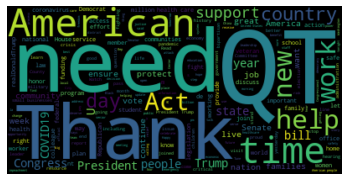

In [18]:
#Converting from string back to list
congress_tweets['tokens'] = congress_tweets['text_deEmojify'].map(lambda x: rem_punc_stop(x))
congress_tweets['tokens']
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text)))
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [19]:
congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))
congress_tweets['tokens']

0       Thank testifying Mr Blake QT JRBlake RepValDem...
1       My Twitter Town Hall healthcare begun I m answ...
2       Scipio Jones ‘ fight civil rights equality imp...
3       There better time ActOnClimate EarthDay We rol...
4       I understand VA problems recruiting qualified ...
                              ...                        
4729    If Senate action week millions struggling fami...
4730    CA epicenter nation COVID19 pandemic SoCal ICU...
4731    Competed Wisconsin State Frog Jump Championshi...
4732    WYPR881FM SenatorCardin joined MiddayWYPR yest...
4733    SecBernhardt RepTjCox This funny RepTJCox call...
Name: tokens, Length: 4734, dtype: object

C:\Users\diana\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


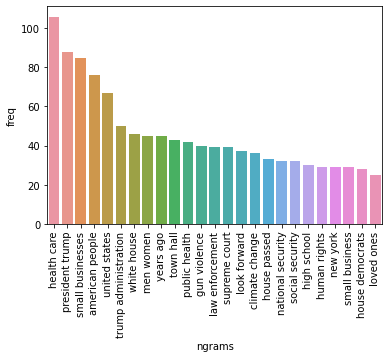

In [20]:
countvec = CountVectorizer(stop_words=STOP_WORDS, ngram_range=(2,2))
ngrams = countvec.fit_transform(congress_tweets['tokens'])

dictionary_dataframe = pd.DataFrame(ngrams.todense(), columns = countvec.get_feature_names())

df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
df_ngram.head()

sns.barplot(x="ngrams", y = 'freq', data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()


### EDA 2: Length and Word Count

In [21]:
congress_tweets['tweet_len'] = congress_tweets['tokens'].apply(len)
congress_tweets['word_count'] = congress_tweets['tokens'].apply(lambda x: len(str(x).split()))

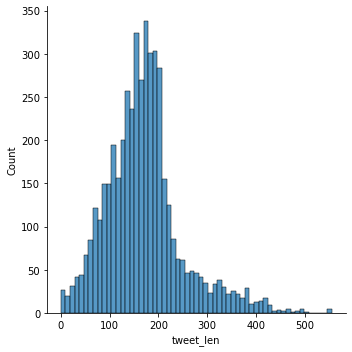

In [22]:
sns.displot(congress_tweets, x="tweet_len")
plt.show()

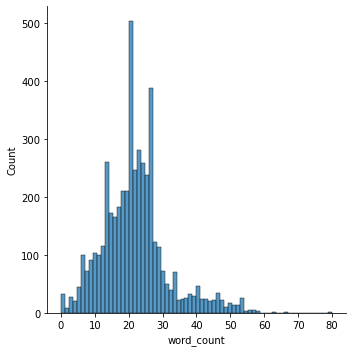

In [23]:
sns.displot(congress_tweets, x="word_count")
plt.show()

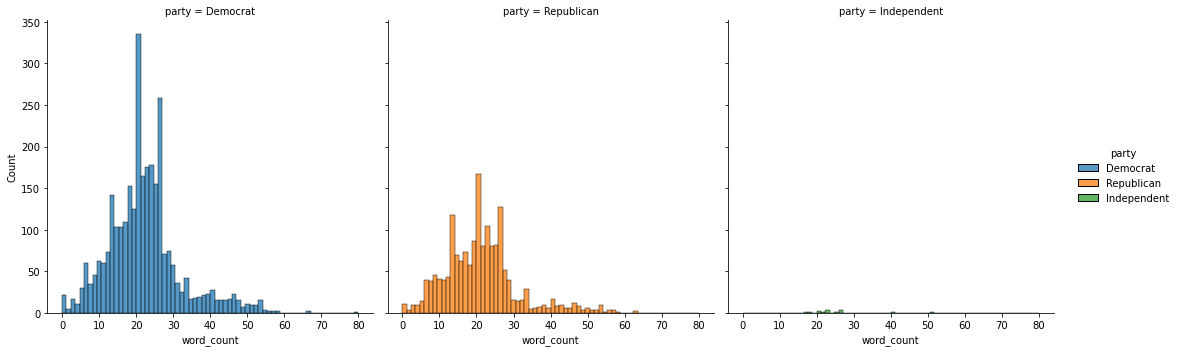

In [24]:
sns.displot(congress_tweets, x="word_count", hue = "party", col = "party")
plt.show()

### Topic Modeling

In [25]:
X = congress_tweets['tokens']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()

In [26]:
lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0)
lda = lda.fit(dense_matrix)

In [27]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [28]:
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #0:
tv interior apply hong kong religious internship fall fishing celebrating sen 4th wishing abortion tips rubio festival navy indiana birthday

Topic #1:
percent congrats carbon uscg flapol jobsreport weallbleedblue stlblues mayor governorkayivey blacklivesmatter timeline parodysassywithmassie gwmacgillivray scavino45 prison repair unbelievable incarcerated bigger

Topic #2:
happy newsletter birthday wishing weekly hanukkah abortion love easter flag doctor christmas land hardball thanksgiving surprise chriscuomo barry floyd cicilline

Topic #3:
   qt need trump president house health help people time work act covid19 american thank new congress country support “

Topic #4:
de el en la y para los que del por se al su las paul ¡ un más immunity información



In [29]:
topic_dist = lda.transform(tfidf_matrix)
topic_dist

array([[0.03836312, 0.03836356, 0.03836389, 0.84654661, 0.03836282],
       [0.04556499, 0.04556398, 0.04556492, 0.81774309, 0.04556302],
       [0.03582166, 0.03548373, 0.03548181, 0.725691  , 0.16752179],
       ...,
       [0.04790701, 0.04791463, 0.04792528, 0.80834701, 0.04790607],
       [0.03233633, 0.03266526, 0.14081627, 0.76190153, 0.03228061],
       [0.03809781, 0.03810013, 0.03810404, 0.84738958, 0.03830844]])

In [30]:
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(congress_tweets.reset_index())
df_w_topics.head()

,0,1,2,3,4,level_0,index,tweet_id,screen_name,datetime,...,percent_obama_12,percent_romney_12,percent_trump16,percent_clinton16,percent_obama12,percent_romney12,sum_2016,sum_2012,tweet_len,word_count
0,0.038363,0.038364,0.038364,0.846547,0.038363,0,217331,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,...,"4,237,756","4,163,447",0.506188,0.493812,0.504423,0.495577,9122861.0,8401203.0,135,19
1,0.045565,0.045564,0.045565,0.817743,0.045563,1,258764,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,...,"1,773,827","2,078,688",0.526612,0.473388,0.460434,0.539566,3967067.0,3852515.0,87,15
2,0.035822,0.035484,0.035482,0.725691,0.167522,2,50091,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,...,"394,409","647,744",0.642851,0.357149,0.378456,0.621544,1065366.0,1042153.0,167,24
3,0.047168,0.047169,0.047168,0.811327,0.047168,3,205601,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,...,"4,237,756","4,163,447",0.506188,0.493812,0.504423,0.495577,9122861.0,8401203.0,105,14
4,0.041390,0.041390,0.041389,0.834442,0.041389,4,85993,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,...,"7,854,285","4,839,958",0.338718,0.661282,0.618728,0.381272,13237606.0,12694243.0,138,19


In [31]:
grouped = df_w_topics.groupby('party')
for i in range(0, 5):
    print(grouped[i].mean().sort_values(ascending=False))

party
Republican     0.097011
Democrat       0.073228
Independent    0.037208
Name: 0, dtype: float64
party
Independent    0.085109
Republican     0.077290
Democrat       0.070717
Name: 1, dtype: float64
party
Republican     0.082761
Democrat       0.077273
Independent    0.060883
Name: 2, dtype: float64
party
Independent    0.779633
Democrat       0.694615
Republican     0.666699
Name: 3, dtype: float64
party
Democrat       0.084167
Republican     0.076239
Independent    0.037166
Name: 4, dtype: float64


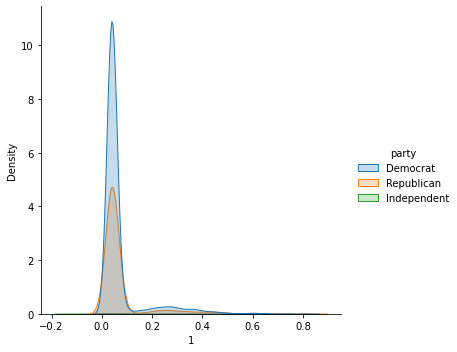

In [34]:
sns.displot(df_w_topics, x=df_w_topics[1], hue = "party", kind = 'kde', fill = 'true')
plt.show()

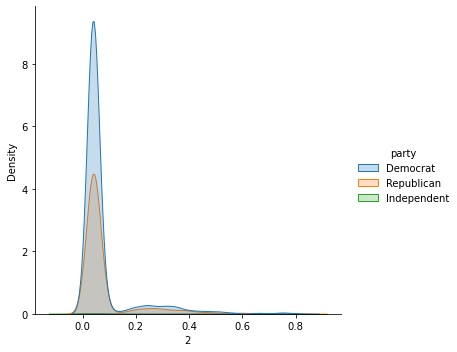

In [35]:
sns.displot(df_w_topics, x=df_w_topics[2], hue = "party", kind = 'kde', fill = 'true')
plt.show()

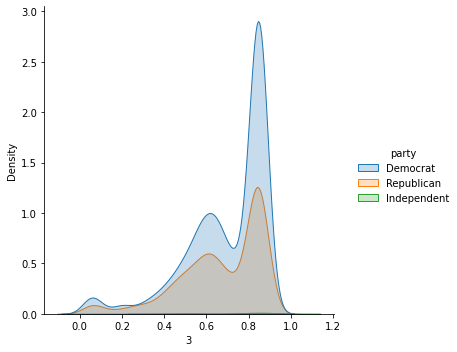

In [36]:
sns.displot(df_w_topics, x=df_w_topics[3], hue = "party", kind = 'kde', fill = 'true')
plt.show()

## 5. Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

### 5.1: Tammy Duckworth (D-IL) vs. Ted Cruz (R-TX)

In [37]:
#Ted Cruz and Tammy Duckworth Tweets
cruz_tweets = congress_tweets[congress_tweets.name_wikipedia == 'Ted Cruz']
duckworth_tweets = congress_tweets[congress_tweets.name_wikipedia == "Tammy Duckworth"]

#Combining dataframes
cruz_duck_df = [cruz_tweets, duckworth_tweets]
cruz_duck_tweets = pd.concat(cruz_duck_df)

#Polarity and Subjectivity
cruz_duck_tweets['polarity'] = cruz_duck_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
cruz_duck_tweets['subjectivity'] = cruz_duck_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

cruz_duck_tweets.head(25)

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,percent_trump16,percent_clinton16,percent_obama12,percent_romney12,sum_2016,sum_2012,tweet_len,word_count,polarity,subjectivity
57,820487,1.279160e+18,SenTedCruz,2020-07-03T17:11:55-04:00,"This weekend, we celebrate the birth of our na...",Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,0.547132,0.452868,0.419921,0.580079,8562915.0,7877967.0,153,20,0.000000,0.000000
238,811947,1.256300e+18,SenTedCruz,2020-05-01T15:29:55-04:00,RT @EricTrump Challenge accepted @SeanHannity!...,Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,0.547132,0.452868,0.419921,0.580079,8562915.0,7877967.0,412,54,0.500000,0.600000
705,797929,1.220850e+18,SenTedCruz,2020-01-24T18:29:25-05:00,My thoughts &amp; prayers are with the familie...,Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,0.547132,0.452868,0.419921,0.580079,8562915.0,7877967.0,406,47,-0.059524,0.238095
755,787860,1.187810e+18,SenTedCruz,2019-10-25T15:26:23-04:00,It’s time for Congress and the American people...,Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,0.547132,0.452868,0.419921,0.580079,8562915.0,7877967.0,160,25,0.150000,0.225000
823,760177,1.088950e+18,SenTedCruz,2019-01-25T18:47:06-05:00,"Yesterday, I fought hard to immediately pay ev...",Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,0.547132,0.452868,0.419921,0.580079,8562915.0,7877967.0,193,28,-0.090774,0.338988
1072,790650,1.196490e+18,SenTedCruz,2019-11-18T13:00:00-05:00,The Trump admin should immediately revoke Iran...,Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,0.547132,0.452868,0.419921,0.580079,8562915.0,7877967.0,172,23,0.000000,0.000000
1230,799251,1.224480e+18,SenTedCruz,2020-02-03T18:56:41-05:00,RT @Astro_Mike #OTD in 1995 STS-63 launched. O...,Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,0.547132,0.452868,0.419921,0.580079,8562915.0,7877967.0,123,18,0.266667,0.300000
1428,776013,1.143620e+18,SenTedCruz,2019-06-25T16:47:32-04:00,RT @dcexaminer The U.S. froze about $100 billi...,Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,0.547132,0.452868,0.419921,0.580079,8562915.0,7877967.0,179,25,0.050000,0.050000
1542,816926,1.270360e+18,SenTedCruz,2020-06-09T10:37:37-04:00,This past weekend “was the most violent weeken...,Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,0.547132,0.452868,0.419921,0.580079,8562915.0,7877967.0,261,24,-0.483333,0.700000
1681,776633,1.146130e+18,SenTedCruz,2019-07-02T14:43:47-04:00,Cruz Asks DHS to Create Process for Collecting...,Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,0.547132,0.452868,0.419921,0.580079,8562915.0,7877967.0,69,10,0.000000,0.000000


### Polarity

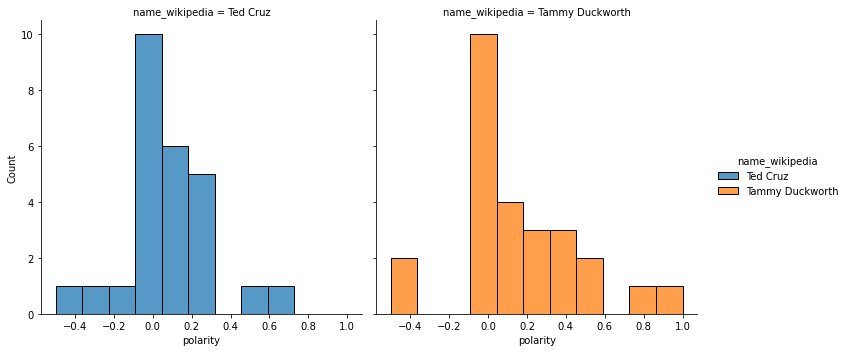

In [38]:
sns.displot(cruz_duck_tweets, x="polarity", hue = "name_wikipedia", col = "name_wikipedia")
plt.show()

### Tweets with the largest polarity

**Tammy Duckworth:**

In [39]:
duckworth_tweets['polarity'] = duckworth_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
for tweets in duckworth_tweets.nlargest(1, "polarity")['text']:
    print(tweets + "\n")

We can do so much more to help survivors of breast cancer return to health and achieve the best quality of life. That's why I'm introducing the Breast Cancer Patient Equity Act with @lisamurkowski, @RepJudyChu &amp; @RepWalorski https://www.duckworth.senate.gov/news/press-releases/-duckworth-murkowski-chu-and-walorski-re-introduce-bipartisan-bicameral-bill-to-expand-coverage-for-breast-cancer-patients-and-survivors



<ipython-input-39-647af7a0291e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duckworth_tweets['polarity'] = duckworth_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)


**Ted Cruz:**

In [40]:
cruz_tweets['polarity'] = cruz_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
for tweets in cruz_tweets.nlargest(1, "polarity")['text']:
    print(tweets + "\n")

RT @xan_desanctis Exclusive: Twenty GOP senators, led by @SenTedCruz, have written to the FDA, asking the commissioner to classify the abortion pill as hazardous and remove it from the market. Details at @NRO: https://www.nationalreview.com/corner/exclusive-gop-senators-ask-the-fda-to-classify-the-abortion-pill-as-dangerous/



<ipython-input-40-0809f2072989>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cruz_tweets['polarity'] = cruz_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)


### Tweets with the smallest polarity

**Tammy Duckworth:**

In [41]:
for tweets in duckworth_tweets.nsmallest(1, "polarity")['text']:
    print(tweets + "\n")

Three years ago today, days after the horrific #PulseShooting, dozens of Congresspeople led by civil rights hero @repjohnlewis gathered on the House floor to stage an historic, 25-hour sit-in demanding a House vote to #EndGunViolence &amp; an end to GOP efforts to block those votes.



**Ted Cruz:**

In [42]:
for tweets in cruz_tweets.nsmallest(1, "polarity")['text']:
    print(tweets + "\n")

This past weekend “was the most violent weekend in Chicago’s history stretching police resources that were already thin because of protests &amp; looting.”
 
It is beyond comprehension that Democrats’ response to this trend would be to reduce police protection.https://chicago.suntimes.com/crime/2020/6/8/21281998/chicago-violence-murder-history-homicide-police-crime



### Subjectivity

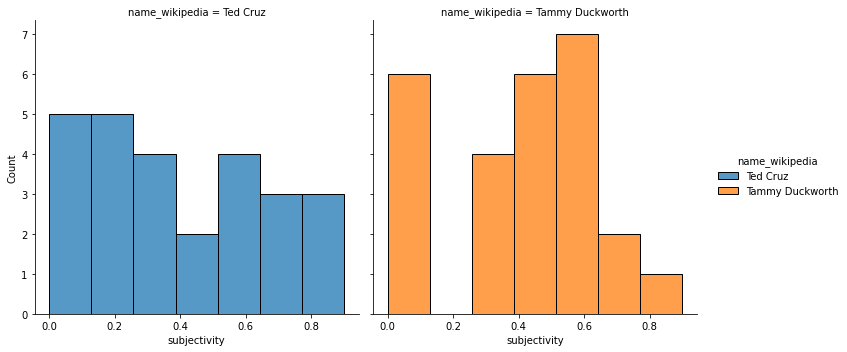

In [43]:
sns.displot(cruz_duck_tweets, x="subjectivity", hue = "name_wikipedia", col = "name_wikipedia")
plt.show()

### Tweets with the largest subjectivity

**Tammy Duckworth:**

In [44]:
duckworth_tweets['subjectivity'] = duckworth_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
for tweets in duckworth_tweets.nlargest(1, 'subjectivity')['text']:
    print(tweets + "\n")

The federal government should treat everyone fairly and be a model employer for all Americans—including those in the disability community. 

I’m disappointed the Trump Administration seems not to be doing that: https://www.nbcnews.com/politics/donald-trump/under-trump-discrimination-complaints-firing-disabled-federal-workers-rise-n1036291



<ipython-input-44-5401f4840256>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duckworth_tweets['subjectivity'] = duckworth_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)


**Ted Cruz**

In [45]:
cruz_tweets['subjectivity'] = cruz_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
for tweets in cruz_tweets.nlargest(1, "subjectivity")['text']:
    print(tweets + "\n")

RT @xan_desanctis Exclusive: Twenty GOP senators, led by @SenTedCruz, have written to the FDA, asking the commissioner to classify the abortion pill as hazardous and remove it from the market. Details at @NRO: https://www.nationalreview.com/corner/exclusive-gop-senators-ask-the-fda-to-classify-the-abortion-pill-as-dangerous/



<ipython-input-45-d66c643106dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cruz_tweets['subjectivity'] = cruz_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)


### Tweets with the smallest subjectivity

**Tammy Duckworth:**

In [46]:
for tweets in duckworth_tweets.nsmallest(1, "subjectivity")['text']:
    print(tweets + "\n")

After my father lost his job when I was a teenager, food stamps and reduced price meals at school helped keep me from going hungry. I wasn’t alone, either: millions of children across our nation rely on #SchoolBreakfast and other nutritious meals too.



**Ted Cruz:**

In [47]:
for tweets in cruz_tweets.nsmallest(1, "subjectivity")['text']:
    print(tweets + "\n")

This weekend, we celebrate the birth of our nation and the gift of independence. Throughout the history of mankind, freedom has been the exception. And yet, here in America, freedom has been delivered and defended for every man, women, and child.



### Sujectivity vs. Polarity

<AxesSubplot:xlabel='polarity', ylabel='subjectivity'>

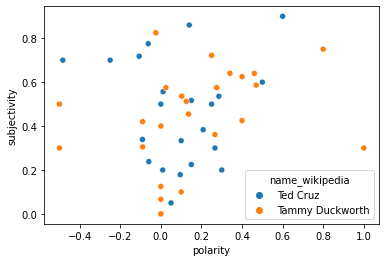

In [48]:
sns.scatterplot(x = cruz_duck_tweets['polarity'], y = cruz_duck_tweets['subjectivity'], hue = cruz_duck_tweets['name_wikipedia'])

### 5.2: Party Affiliation and Bodies of Congress

### Polarity 

In [49]:
congress_tweets['polarity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)

**Party Affiliation**

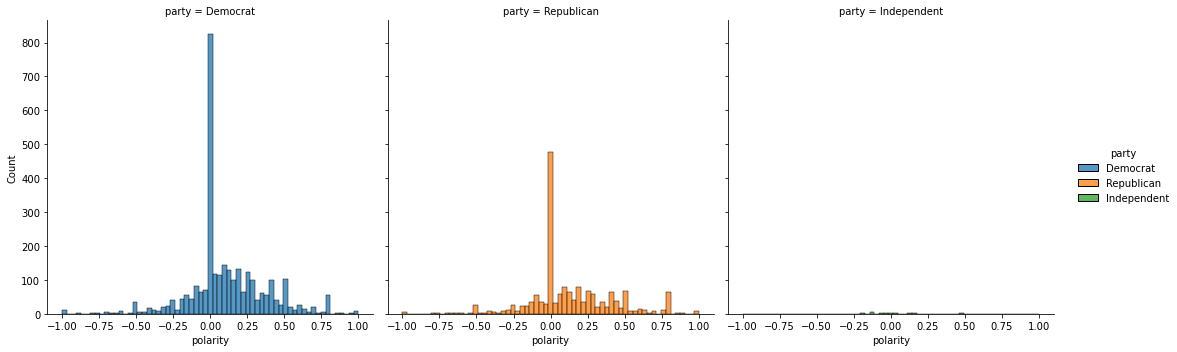

In [50]:
#By Party
sns.displot(congress_tweets, x="polarity", hue = "party", col = "party")
plt.show()

**Bodies of Congress**

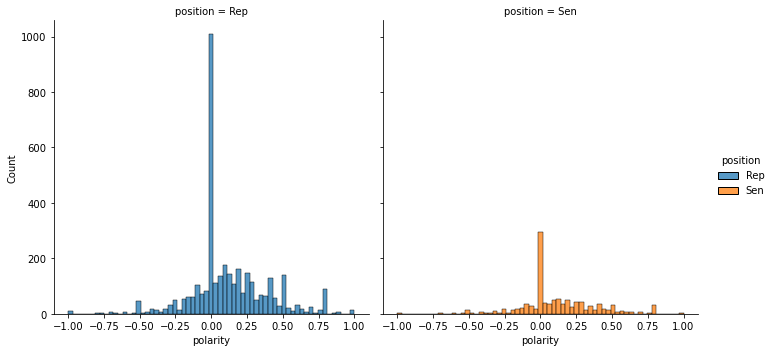

In [52]:
sns.displot(congress_tweets, x="polarity", hue = "position", col = "position")
plt.show()

### Subjectivity

In [53]:
congress_tweets['subjectivity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

**Party Affiliation**

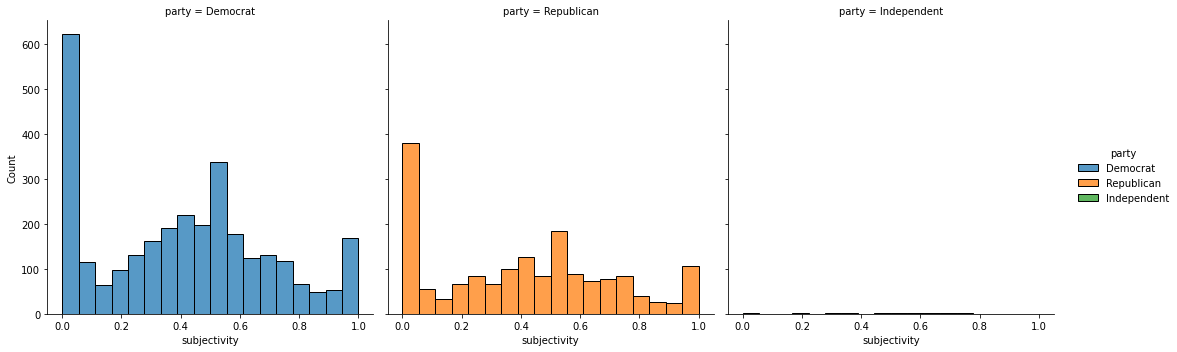

In [54]:
#by party
sns.displot(congress_tweets, x="subjectivity", hue = "party", col = "party")
plt.show()

**Bodies of Congress**

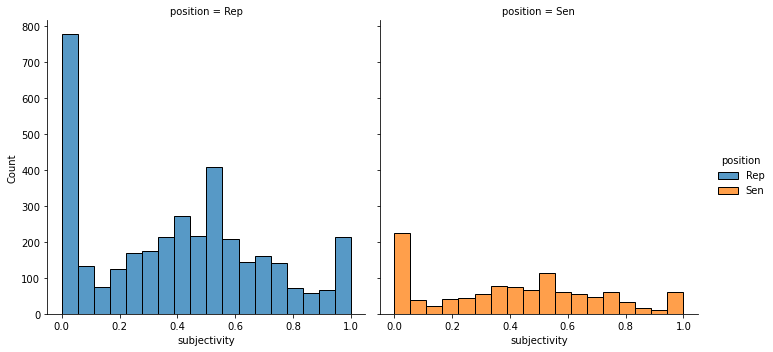

In [55]:
sns.displot(congress_tweets, x="subjectivity", hue = "position", col = "position")
plt.show()

## 6. Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [56]:
congress_tweets.columns

Index(['index', 'tweet_id', 'screen_name', 'datetime', 'text',
       'name_wikipedia', 'position', 'joined_congress_date', 'birthday',
       'gender', 'state', 'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'text_deEmojify', 'tokens',
       'percent_trump_16', 'percent_clinton_16', 'percent_obama_12',
       'percent_romney_12', 'percent_trump16', 'percent_clinton16',
       'percent_obama12', 'percent_romney12', 'sum_2016', 'sum_2012',
       'tweet_len', 'word_count', 'polarity', 'subjectivity'],
      dtype='object')

### Engineered Text Features

In [57]:
# Engineered Text Features
engineered_features = congress_tweets[['tweet_len', 'word_count', 'polarity', 'subjectivity']].reset_index(drop = True)

In [59]:
# Topic Model + Engineered Features
engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True))

In [63]:
# Non-text features
non_text_features_cat = congress_tweets[['position', 'joined_congress_date','gender', 'state']]

non_text_features_cont = congress_tweets[['percent_trump16', 'percent_clinton16', 'percent_obama12','percent_romney12']]  

non_text_features_dummies = pd.get_dummies(non_text_features_cat).reset_index(drop = True)

non_text_features = (non_text_features_dummies).reset_index(drop = True).join(non_text_features_cont)

In [64]:
non_text_features.head()

,position_Rep,position_Sen,joined_congress_date_10-Apr-18,joined_congress_date_10-Jul-18,joined_congress_date_10-Mar-05,joined_congress_date_10-May-94,joined_congress_date_10-Sep-15,joined_congress_date_11-Apr-13,joined_congress_date_11-Dec-07,joined_congress_date_11-Jul-17,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,percent_trump16,percent_clinton16,percent_obama12,percent_romney12
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.506188,0.493812,0.504423,0.495577
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.526612,0.473388,0.460434,0.539566
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.642851,0.357149,0.378456,0.621544
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.506188,0.493812,0.504423,0.495577
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.338718,0.661282,0.618728,0.381272


In [65]:
# Non-text features + engineered features
non_text_engineered_features = non_text_features.reset_index(drop = True).join(engineered_features_with_topics)

### Tf-idf 

In [66]:
# Non-text features + tfidf
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())
non_text_plus_tfidf = non_text_features_dummies.reset_index(drop = True).join(tfidf_df)

### Dictionary with top 25 n-grams

In [67]:
countvec = CountVectorizer(stop_words=STOP_WORDS, ngram_range=(2,3))
ngrams = countvec.fit_transform(congress_tweets['tokens'])

dictionary_dataframe = pd.DataFrame(ngrams.todense(), columns = countvec.get_feature_names())

df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)

top_25_ngrams = dictionary_dataframe.loc[:,df_ngram[0:25]['ngrams']]
top_25_ngrams.head()

C:\Users\diana\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,health care,president trump,small businesses,american people,united states,trump administration,white house,men women,years ago,town hall,...,climate change,house passed,national security,social security,high school,human rights,small business,new york,house democrats,qt realdonaldtrump
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
# Top 25 ngrams + non-text
non_text_with_ngrams = non_text_features.reset_index(drop = True).join(top_25_ngrams)

### Embedding Based Featurization

In [69]:
#Converting from string back to list
congress_tweets['tokens'] = congress_tweets['text_deEmojify'].map(lambda x: rem_punc_stop(x))
congress_tweets['tokens']

0       [Thank, testifying, Mr, Blake, QT, JRBlake, Re...
1       [My, Twitter, Town, Hall, healthcare, begun, I...
2       [Scipio, Jones, ‘, fight, civil, rights, equal...
3       [There, better, time, ActOnClimate, EarthDay, ...
4       [I, understand, VA, problems, recruiting, qual...
                              ...                        
4729    [If, Senate, action, week, millions, strugglin...
4730    [CA, epicenter, nation, COVID19, pandemic, SoC...
4731    [Competed, Wisconsin, State, Frog, Jump, Champ...
4732    [WYPR881FM, SenatorCardin, joined, MiddayWYPR,...
4733    [SecBernhardt, RepTjCox, This, funny, RepTJCox...
Name: tokens, Length: 4734, dtype: object

In [71]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [73]:
# retrain congress_tweets['tokens'] model so it has the same dimensions as the google vector
word2vec_model = gensim.models.Word2Vec(size = 300, window=5, min_count = 1, workers = 3)
 
word2vec_model.build_vocab(congress_tweets['tokens'])
 
# set lockf = 1 to allow updating
 
word2vec_model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True)
 
# Finish training model
word2vec_model.train(congress_tweets['tokens'], total_examples=3, epochs = 5)

(507008, 521650)

In [74]:
words = list(word2vec_model.wv.vocab)
print(words[0:100])

['Thank', 'testifying', 'Mr', 'Blake', 'QT', 'JRBlake', 'RepValDemings', 'gave', 'impassioned', 'speech', 'place', 'experience', 'having', 'served', '27', 'years', 'police', 'force', ' ', 'My', 'Twitter', 'Town', 'Hall', 'healthcare', 'begun', 'I', 'm', 'answering', 'questions', 'live', 'Please', 'hit', 'w', 'AskHank', 'Scipio', 'Jones', '‘', 'fight', 'civil', 'rights', 'equality', 'important', 'Arkansas', 'history', 'deeply', 'proud', 'LittleRock', 'like', 'thank', 'GOPoversight', 'quickly', 'marking', 'legislation', 'pass', 'House', 'Floor', '22', 'There', 'better', 'time', 'ActOnClimate', 'EarthDay', 'We', 'role', 'play', 'protecting', 'Earth', 'It', 'responsibility', 'neglect', 'understand', 'VA', 'problems', 'recruiting', 'qualified', 'physicians', 'working', 'personnel', 'craft', 'help', 'hiring', 'process', 'alleviate', 'concerns', 'Johnson4Dallas', 'This', 'accurate', 'description', 'current', 'City', 'Dallas', 'budget', 'debate', 'surrounding', 'noise', 'read', 'far', 'Kudos',

In [75]:
doc = [word for word in congress_tweets['tokens'][0] if word in word2vec_model.wv.vocab]
len(doc)

20

In [76]:
first_vec = []
for token in word2vec_model.wv.__getitem__(doc):
    first_vec.append(token[0])
numpy.mean(first_vec)

0.0010543115

In [77]:
def document_vector(word2vec_model, doc):
    doc = [word for word in congress_tweets['tokens'][0] if word in word2vec_model.wv.vocab]
    return numpy.mean(word2vec_model.wv.__getitem__(doc), axis=0)

In [78]:
# Initialize an array for the size of the corpus
empty_list_embeddings_means = []
for doc in congress_tweets['tokens']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(word2vec_model, doc))
    
doc_average_embeddings = numpy.array(empty_list_embeddings_means) # list to array

In [79]:
doc_average_embeddings

array([[ 0.00105431,  0.04460625,  0.03092963, ..., -0.0821604 ,
         0.01735081, -0.00029636],
       [ 0.00105431,  0.04460625,  0.03092963, ..., -0.0821604 ,
         0.01735081, -0.00029636],
       [ 0.00105431,  0.04460625,  0.03092963, ..., -0.0821604 ,
         0.01735081, -0.00029636],
       ...,
       [ 0.00105431,  0.04460625,  0.03092963, ..., -0.0821604 ,
         0.01735081, -0.00029636],
       [ 0.00105431,  0.04460625,  0.03092963, ..., -0.0821604 ,
         0.01735081, -0.00029636],
       [ 0.00105431,  0.04460625,  0.03092963, ..., -0.0821604 ,
         0.01735081, -0.00029636]], dtype=float32)

In [80]:
word2vec_features_df = pd.DataFrame(doc_average_embeddings)

## 7. Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [81]:
congress_tweets.loc[congress_tweets['party'] == "Independent"]

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,percent_trump16,percent_clinton16,percent_obama12,percent_romney12,sum_2016,sum_2012,tweet_len,word_count,polarity,subjectivity
475,850253,1.135930e+18,SenSanders,2019-06-04T11:41:20-04:00,I believe it is wrong to charge Americans astr...,Bernie Sanders,Sen,3-Jan-07,9/8/1941,M,...,0.348136,0.651864,0.682473,0.317527,273942.0,291937.0,196,23,-0.200000,0.600000
700,850782,1.153670e+18,SenSanders,2019-07-23T10:27:29-04:00,Teachers are facing outrageous levels of stude...,Bernie Sanders,Sen,3-Jan-07,9/8/1941,M,...,0.348136,0.651864,0.682473,0.317527,273942.0,291937.0,201,25,-0.066667,0.688889
942,849015,1.089210e+18,SenSanders,2019-01-26T12:15:57-05:00,"Thank you air traffic controllers, flight atte...",Bernie Sanders,Sen,3-Jan-07,9/8/1941,M,...,0.348136,0.651864,0.682473,0.317527,273942.0,291937.0,215,27,-0.125000,0.625000
1118,849302,1.096500e+18,SenSanders,2019-02-15T15:21:28-05:00,The current fight in DC is about more than a w...,Bernie Sanders,Sen,3-Jan-07,9/8/1941,M,...,0.348136,0.651864,0.682473,0.317527,273942.0,291937.0,145,20,0.000000,0.200000
1276,854019,1.278820e+18,SenSanders,2020-07-02T18:56:43-04:00,RT @RepChuyGarcia Proud to work with @SenatorD...,Bernie Sanders,Sen,3-Jan-07,9/8/1941,M,...,0.348136,0.651864,0.682473,0.317527,273942.0,291937.0,335,40,0.160000,0.200000
1814,850646,1.148960e+18,SenSanders,2019-07-10T10:12:05-04:00,RT @RepRoKhanna My #NDAA Amendment will end al...,Bernie Sanders,Sen,3-Jan-07,9/8/1941,M,...,0.348136,0.651864,0.682473,0.317527,273942.0,291937.0,143,22,0.000000,0.000000
2158,852117,1.207380e+18,SenSanders,2019-12-18T14:17:06-05:00,RT @repmarkpocan Americans want monumental sol...,Bernie Sanders,Sen,3-Jan-07,9/8/1941,M,...,0.348136,0.651864,0.682473,0.317527,273942.0,291937.0,212,26,-0.031818,0.377273
2739,849019,1.089590e+18,SenSanders,2019-01-27T13:22:06-05:00,"Today, on Holocaust Remembrance Day, we pledge...",Bernie Sanders,Sen,3-Jan-07,9/8/1941,M,...,0.348136,0.651864,0.682473,0.317527,273942.0,291937.0,152,20,0.000000,0.000000
3136,850127,1.129450e+18,SenSanders,2019-05-17T13:56:37-04:00,To the @SenateMajldr: The House did its job. N...,Bernie Sanders,Sen,3-Jan-07,9/8/1941,M,...,0.348136,0.651864,0.682473,0.317527,273942.0,291937.0,375,51,0.016667,0.530556
3188,854795,1.322270e+18,SenSanders,2020-10-30T16:25:30-04:00,While 12 million Americans recently lost their...,Bernie Sanders,Sen,3-Jan-07,9/8/1941,M,...,0.348136,0.651864,0.682473,0.317527,273942.0,291937.0,214,26,-0.142857,0.452143


In [82]:
congress_tweets['ReporDem'] = congress_tweets['party'].apply(lambda x: 0 if x=='Democrat' and x!='Independent' else 1)
congress_tweets.head()

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,percent_clinton16,percent_obama12,percent_romney12,sum_2016,sum_2012,tweet_len,word_count,polarity,subjectivity,ReporDem
0,217331,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. http...,Val Demings,Rep,3-Jan-17,3/12/1957,F,...,0.493812,0.504423,0.495577,9122861.0,8401203.0,135,19,0.000000,0.000000,0
1,258764,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,...,0.473388,0.460434,0.539566,3967067.0,3852515.0,87,15,0.136364,0.500000,0
2,50091,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,...,0.357149,0.378456,0.621544,1065366.0,1042153.0,167,24,0.511111,0.833333,1
3,205601,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,...,0.493812,0.504423,0.495577,9122861.0,8401203.0,105,14,0.450000,0.750000,0
4,85993,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,...,0.661282,0.618728,0.381272,13237606.0,12694243.0,138,19,0.000000,0.000000,1


In [83]:
congress_tweets.dtypes

index                         int64
tweet_id                    float64
screen_name                  object
datetime                     object
text                         object
name_wikipedia               object
position                     object
joined_congress_date         object
birthday                     object
gender                       object
state                        object
district_number              object
party                        object
trump_2016_state_share       object
clinton_2016_state_share     object
obama_2012_state_share       object
romney_2012_state_share      object
text_deEmojify               object
tokens                       object
percent_trump_16             object
percent_clinton_16           object
percent_obama_12             object
percent_romney_12            object
percent_trump16             float64
percent_clinton16           float64
percent_obama12             float64
percent_romney12            float64
sum_2016                    

In [84]:
X

0       Thank testifying Mr Blake QT JRBlake RepValDem...
1       My Twitter Town Hall healthcare begun I m answ...
2       Scipio Jones ‘ fight civil rights equality imp...
3       There better time ActOnClimate EarthDay We rol...
4       I understand VA problems recruiting qualified ...
                              ...                        
4729    If Senate action week millions struggling fami...
4730    CA epicenter nation COVID19 pandemic SoCal ICU...
4731    Competed Wisconsin State Frog Jump Championshi...
4732    WYPR881FM SenatorCardin joined MiddayWYPR yest...
4733    SecBernhardt RepTjCox This funny RepTJCox call...
Name: tokens, Length: 4734, dtype: object

In [85]:
##train the Y and do the thing you need to do 
dataframes = [engineered_features, 
              engineered_features_with_topics,
              non_text_features_dummies,
              non_text_engineered_features,
              tfidf_df, 
              non_text_plus_tfidf,
             top_25_ngrams,
             non_text_with_ngrams,
            word2vec_features_df]

featurization_technique = ['Engineered Text Features',
                            'Engineered Features + Topic Model',
                           'Non-Text Features',
                           'Non-Text + Engineered Text Features',
                           'Tf-idf Features',
                           'Non-Text + Tf-idf Features',
                          'Top 25 N-Gram Features',
                          'Non-Text + Top 25 N-Gram Features',
                          'word2vec_features_df']

                          
lb_style = LabelBinarizer()
y = lb_style.fit_transform(congress_tweets["ReporDem"])

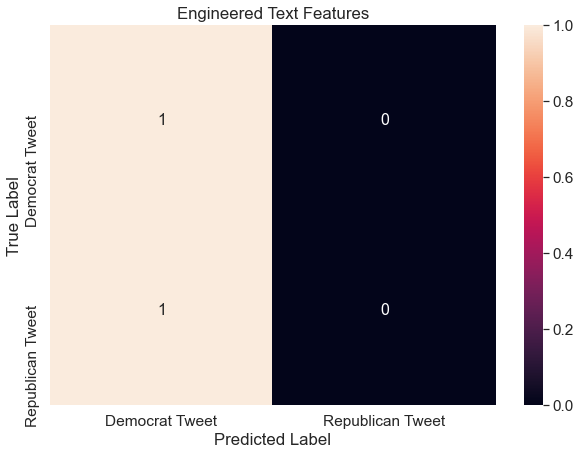

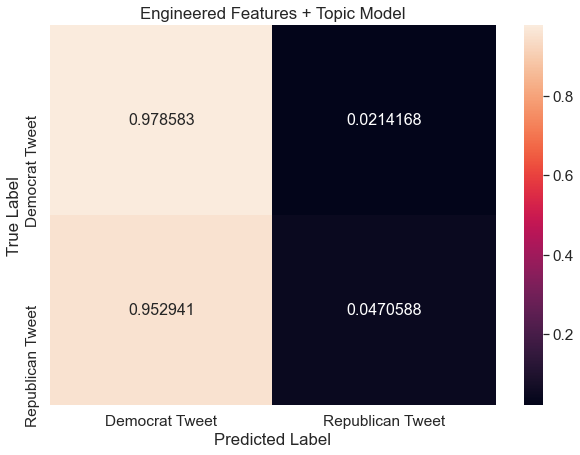

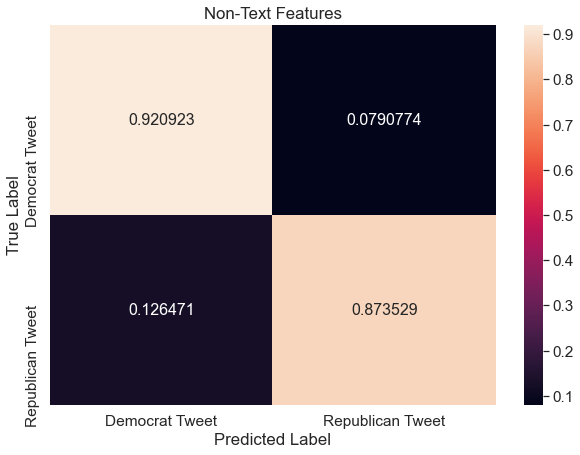

C:\Users\diana\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


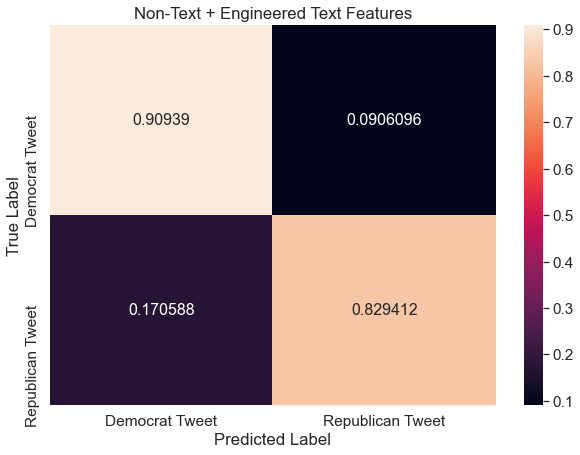

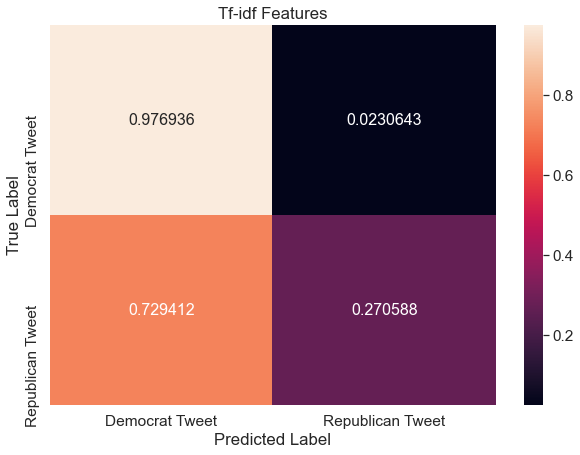

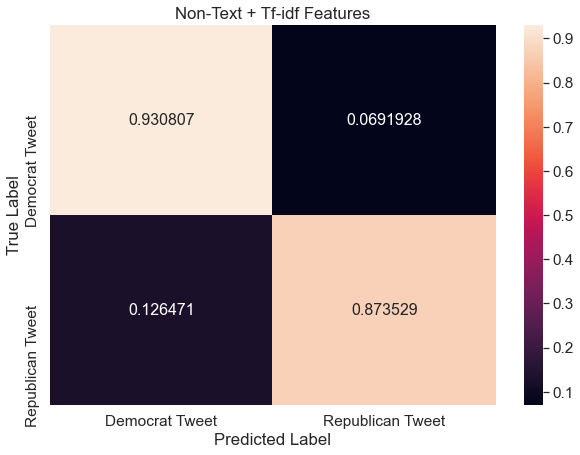

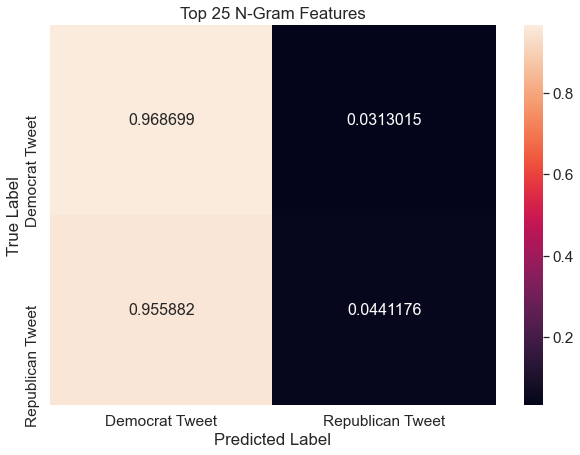

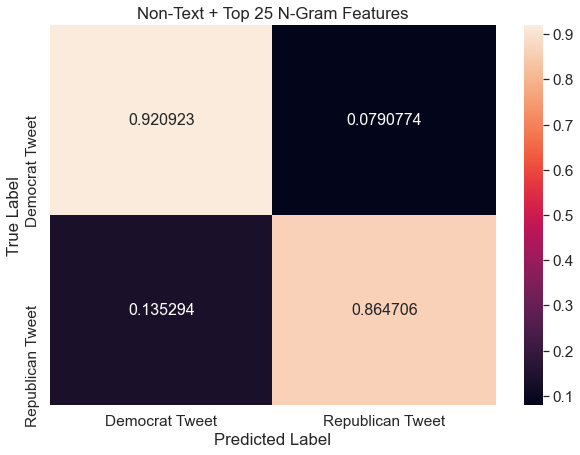

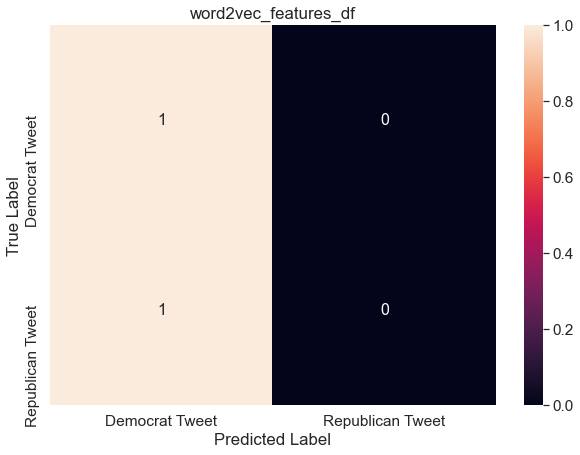

In [86]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])

##There are the first three models with democrat and republican 
for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression(max_iter=200)
    
    # fit the model
    #logit_model = logit_reg_extra.fit(X_train, y_train.ravel())
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Democrat Tweet", 1: "Republican Tweet"})
    df_cm.index = ["Democrat Tweet", "Republican Tweet"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [87]:
congress_tweets.head()

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,percent_clinton16,percent_obama12,percent_romney12,sum_2016,sum_2012,tweet_len,word_count,polarity,subjectivity,ReporDem
0,217331,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. http...,Val Demings,Rep,3-Jan-17,3/12/1957,F,...,0.493812,0.504423,0.495577,9122861.0,8401203.0,135,19,0.000000,0.000000,0
1,258764,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,...,0.473388,0.460434,0.539566,3967067.0,3852515.0,87,15,0.136364,0.500000,0
2,50091,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,...,0.357149,0.378456,0.621544,1065366.0,1042153.0,167,24,0.511111,0.833333,1
3,205601,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,...,0.493812,0.504423,0.495577,9122861.0,8401203.0,105,14,0.450000,0.750000,0
4,85993,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,...,0.661282,0.618728,0.381272,13237606.0,12694243.0,138,19,0.000000,0.000000,1


<AxesSubplot:xlabel='polarity', ylabel='subjectivity'>

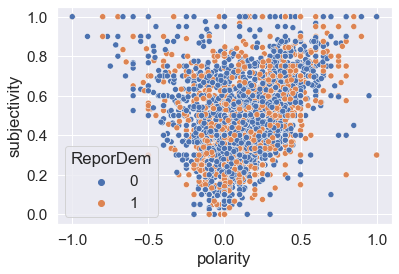

In [88]:
sns.scatterplot(x = congress_tweets['polarity'], y = congress_tweets['subjectivity'], hue = congress_tweets['ReporDem'])

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])


...

## 8. Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**